In [1]:
import warnings
warnings.filterwarnings("ignore")

# Parte 1

Muchos de los servicios principales de MELI son públicos, lo cual permite acceder a
los datos de forma sencilla. En la primera parte del desafío el objetivo es realizar un
análisis exploratorio de las publicaciones con descuento del marketplace. Las
preguntas a responder y el enfoque del análisis son libres , como punto de partida
se puede sugiere utilizar la api de search de mercadolibre, la cual está por detrás del
buscador de Mercadolibre.

* Las publicaciones con precio con descuento son aquellas que poseen el campo original_price
!= null

La información corresponde a una búsqueda realizada en Meli versión Argentina de “tv’s”. Esta búsqueda arrojó 19617 resultados, de los cuáles solo analizaremos los primeros 50 (de acuerdo a relevancia).

Cargamos la data dispuesta en .json y luego la estructuramos como un pandas dataframe

In [2]:
import requests
r = requests.get('https://api.mercadolibre.com/sites/MLA/search?q=tv%2#json')
my_dict = r.json()
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df=pd.DataFrame.from_dict(my_dict["results"])

Realizamos una mirada general de esta data:
- Cantidad de registros y de features.
- Variables con datos nulos
- Estructura de las variables

In [3]:
print("Son "+str(df.shape[0])+" resultados/registros y se tienen "+str(df.shape[1])+" features")

Son 50 resultados/registros y se tienen 39 features


In [4]:
df.isnull().sum()

id                       0
site_id                  0
title                    0
seller                   0
price                    0
prices                   0
sale_price              50
currency_id              0
available_quantity       0
sold_quantity            0
buying_mode              0
listing_type_id          0
stop_time                0
condition                0
permalink                0
thumbnail                0
thumbnail_id             0
accepts_mercadopago      0
installments             0
address                  0
shipping                 0
seller_address           0
attributes               0
original_price          25
category_id              0
official_store_id       29
domain_id                0
catalog_product_id       1
tags                     0
catalog_listing          7
use_thumbnail_id         0
offer_score             50
offer_share             50
match_score             50
winner_item_id          50
melicoin                50
discounts               50
o

In [5]:
print("Se tienen "+str(sum(df.isnull().sum()>0))+" features con valores nulos.")
print("Las variables con nulos son: "+str(((df.isnull().sum()>0).reset_index()[(df.isnull().sum()>0).reset_index(
).iloc[:,1]==True]).iloc[:,0].values))

Se tienen 12 features con valores nulos.
Las variables con nulos son: ['sale_price' 'original_price' 'official_store_id' 'catalog_product_id'
 'catalog_listing' 'offer_score' 'offer_share' 'match_score'
 'winner_item_id' 'melicoin' 'discounts' 'differential_pricing']


In [6]:
print("Se tienen "+str(sum(df.isnull().sum()==50))+" features que están completamente nulas, en todos sus registros.")
print("Las variables son: "+str(((df.isnull().sum()>0).reset_index()[(df.isnull().sum()==50).reset_index().iloc[:,1]==True]
                                ).iloc[:,0].values))
print("Estas las sacaremos del análisis pues no aportan.")

Se tienen 7 features que están completamente nulas, en todos sus registros.
Las variables son: ['sale_price' 'offer_score' 'offer_share' 'match_score' 'winner_item_id'
 'melicoin' 'discounts']
Estas las sacaremos del análisis pues no aportan.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    50 non-null     object 
 1   site_id               50 non-null     object 
 2   title                 50 non-null     object 
 3   seller                50 non-null     object 
 4   price                 50 non-null     float64
 5   prices                50 non-null     object 
 6   sale_price            0 non-null      object 
 7   currency_id           50 non-null     object 
 8   available_quantity    50 non-null     int64  
 9   sold_quantity         50 non-null     int64  
 10  buying_mode           50 non-null     object 
 11  listing_type_id       50 non-null     object 
 12  stop_time             50 non-null     object 
 13  condition             50 non-null     object 
 14  permalink             50 non-null     object 
 15  thumbnail             50 

- En algunas de las features, existe una anidación de información que está en formato dict. Estas son: seller, prices, installments, address, shipping, seller_address, attributes y tags. En aquellas features indagaremos más.
- Se tienen 3 features que son numéricas: price, available_quantity, sold_quantity y original_price
- Las restantes aluden a identificadores y/o características de las publicaciones (variables categóricas).

In [8]:
df_tm=((((df.isnull().sum()>0) & (df.isnull().sum()<50)) | (df.isnull().sum()==0) ).reset_index())
name_1=df_tm[df_tm.iloc[:,1]==True].iloc[:,0]
df_1=df[name_1]

A partir features existentes, vamos a crear otras para complementar el análisis:

In [9]:
import numpy as np
#Si el producto tiene descuento en el precio original.
df_1['discount'] = np.where(df_1['original_price'].isnull(),0,1)

#Porcentaje de unidades vendidas del producto.
df_1['porc_sold'] = df_1['sold_quantity']/(df_1['available_quantity'] + df_1['sold_quantity'])*100.00

#Porcentaje de descuento en el precio del producto.
df_1['P_discount'] = (df_1.original_price-df_1.price)/df_1.original_price*100

Podemos complementar este análisis, obtendremos otras features de a partir de aquellas que están anidadas:
- installments (cuotas): quantity - amount - rate
- address: state_name
- attributes: Peso - Largo del paquete - Peso del paquete

In [10]:
from pandas import json_normalize

df_t2 = json_normalize(df_1.installments, max_level=0)
df_1 = pd.merge(df_1,df_t2,left_index=True,right_index=True,how='inner')

df_t3 = json_normalize(df_1.address, max_level=0)
df_1 = pd.merge(df_1,df_t3,left_index=True,right_index=True,how='inner')

df_t6=0
for i in range(50):
    if i==0:
        a1=json_normalize(df_1.attributes[i], max_level=0)[['id','name','value_name']]
        df_t6=(a1[(a1.id=='PACKAGE_LENGTH') | (a1.id=='PACKAGE_WEIGHT') | (a1.id=='WEIGHT')][['name','value_name']].set_index(
            'name',inplace=False)).transpose()
    else:
        a1=json_normalize(df_1.attributes[i], max_level=0)[['id','name','value_name']]
        at=(a1[(a1.id=='PACKAGE_LENGTH') | (a1.id=='PACKAGE_WEIGHT') | (a1.id=='WEIGHT')][['name','value_name']].set_index(
            'name',inplace=False)).transpose()
        df_t6 = pd.concat([df_t6,at],axis=0)
        
tmp=(df_t6.reset_index().drop(['index'],axis=1))
tmp.Peso=(pd.Series(tmp.Peso).replace(to_replace='kg', value='',inplace=False,regex=True).values).astype("float64")
tmp['Largo del paquete']=(pd.Series(tmp['Largo del paquete']).replace(to_replace='cm', value='',inplace=False,regex=True
                                                                     ).values).astype("float64")
tmp['Peso del paquete']=(pd.Series(tmp['Peso del paquete']).replace(to_replace='g', value='',inplace=False,regex=True).values
                        ).astype("float64")

df_1 = pd.merge(df_1,(tmp.reset_index().drop(['index'],axis=1)),left_index=True,right_index=True,how='inner')
df_1[['discount','price','available_quantity','sold_quantity','original_price','porc_sold','P_discount','quantity','amount',
      'Peso','Largo del paquete','Peso del paquete']] = df_1[['discount','price','available_quantity','sold_quantity',
                                                              'original_price','porc_sold','P_discount','quantity','amount',
                                                              'Peso','Largo del paquete','Peso del paquete']].fillna(0)

Análisis de medidas de tendencia central y dispersión en variables cuantitativas:

In [11]:
df_1[['discount','price','available_quantity','sold_quantity','original_price','porc_sold','P_discount','quantity',
      'amount','Peso','Largo del paquete','Peso del paquete']].groupby(['discount']).describe()

price                                                                         available_quantity                                                      sold_quantity                                                       original_price                                                                       porc_sold                                                                              P_discount                                                                          quantity                                               amount                                                                         Peso                                              Largo del paquete                                                Peso del paquete                                                        
         count        mean           std     min      25%      50%       75%       max              count    mean         std  min   25%    50%    75%     max         count    mean          std  min   25%    50%    75%     max          count       mean           std     min      25%      50%      75%       max     count       mean        std        min        25%        50%        75%        max      count       mean       std       min       25%       50%        75%        max    count   mean       std  min   25%   50%   75%   max  count       mean          std      min      25%      50%       75%       max count    mean       std  min  25%  50%   75%   max             count    mean        std  min  25%   50%   75%   max            count    mean          std  min  25%     50%     75%      max
discount                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
0         25.0  65495.7560  42966.954931  6799.0  33999.0  51999.0  83999.00  198850.0               25.0   75.28  111.980474  1.0   4.0   24.0  100.0   467.0          25.0  229.56   323.242824  4.0  21.0   93.0  335.0  1411.0           25.0      0.000      0.000000     0.0      0.0      0.0      0.0       0.0      25.0  71.138238  28.010615   3.731343  53.333333  80.591260  89.473684  99.416342       25.0   0.000000  0.000000  0.000000  0.000000   0.00000   0.000000   0.000000     25.0  11.64  1.800000  3.0  12.0  12.0  12.0  12.0   25.0  8969.5384  5037.069691   964.15  4821.34  8020.82  11911.76  18860.37  25.0  8.2272  8.857522  0.0  0.0  6.7  11.6  37.0              25.0   3.812   6.434304  0.0  0.0   0.0  10.0  18.9             25.0  2047.6  3593.235868  0.0  0.0     0.0  4100.0  11000.0
1         25.0  52009.9472  27721.105989  8599.0  35999.0  44999.0  64855.03  149999.0               25.0  307.12  422.965554  1.0  32.0  113.0  433.0  1459.0          25.0  741.28  1501.006399  4.0  82.0  347.0  512.0  7343.0           25.0  59520.432  31752.868096  9249.0  40999.0  51999.0  73699.9  166666.0      25.0  67.024035  26.931696  13.226453  50.000000  76.806589  90.909091  99.514563       25.0  11.738907  8.411706  1.724168  4.776262  10.00024  16.071716  34.991109     25.0   9.96  3.746999  3.0  12.0  12.0  12.0  12.0   25.0  7826.8124  4522.642927  1433.17  4254.11  6333.25  11769.95  15666.33  25.0  5.9468  4.049866  0.0  3.8  6.3   9.1  15.5              25.0  23.404  29.107208  0.0  0.0  16.0  20.0  88.0             25.0  4901.6  4445.210606  0.0  0.0  5260.0  

Encontramos diferencias a nivel de media y mediana en productos con descuento de los sin descuento, en las features price, available_quantity, sold_quantity, Largo del paquete y Peso del paquete.

A nivel gráfico:

Text(0.5, 1.0, 'Peso del paquete según estado del descuento')

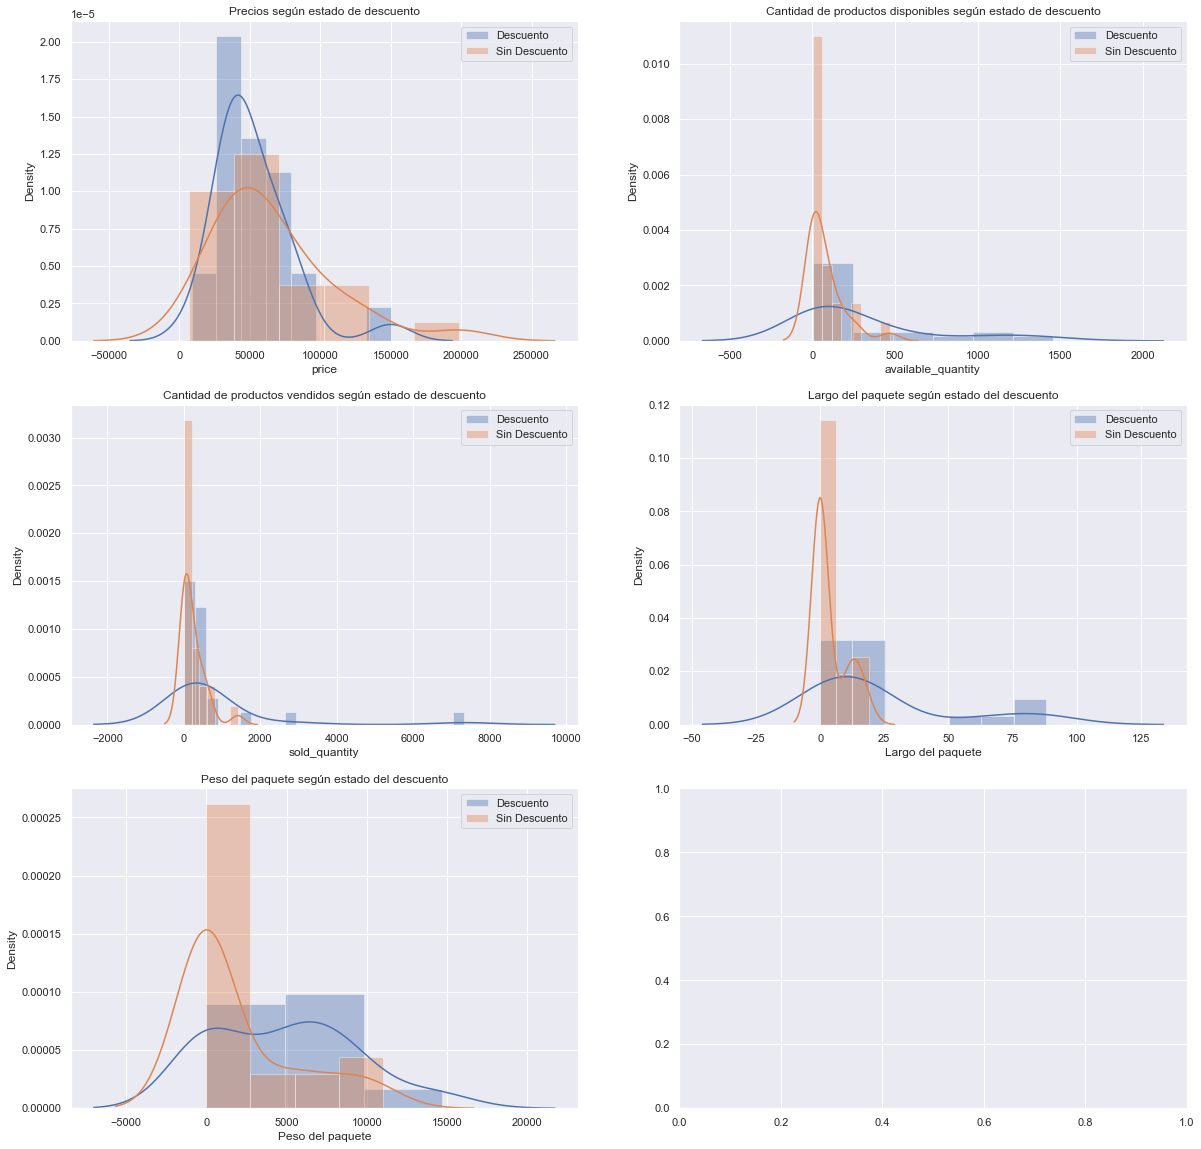

In [53]:
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

sns.set(rc={"figure.figsize":(20, 20)})
fig, axes = plt.subplots(3, 2)
sns.distplot(df_1[df_1.discount==1].price,label="Descuento",ax = axes[0][0])
sns.distplot(df_1[df_1.discount==0].price,label="Sin Descuento",ax = axes[0][0])
axes[0][0].legend()
axes[0][0].set_title("Precios según estado de descuento")

sns.distplot(df_1[df_1.discount==1].available_quantity,label="Descuento",ax = axes[0][1])
sns.distplot(df_1[df_1.discount==0].available_quantity,label="Sin Descuento",ax = axes[0][1])
axes[0][1].legend()
axes[0][1].set_title("Cantidad de productos disponibles según estado de descuento")

sns.distplot(df_1[df_1.discount==1].sold_quantity,label="Descuento",ax = axes[1][0])
sns.distplot(df_1[df_1.discount==0].sold_quantity,label="Sin Descuento",ax = axes[1][0])
axes[1][0].legend()
axes[1][0].set_title("Cantidad de productos vendidos según estado de descuento")

sns.distplot(df_1[df_1.discount==1]['Largo del paquete'],label="Descuento",ax = axes[1][1])
sns.distplot(df_1[df_1.discount==0]['Largo del paquete'],label="Sin Descuento",ax = axes[1][1])
axes[1][1].legend()
axes[1][1].set_title("Largo del paquete según estado del descuento")

sns.distplot(df_1[df_1.discount==1]['Peso del paquete'],label="Descuento",ax = axes[2][0])
sns.distplot(df_1[df_1.discount==0]['Peso del paquete'],label="Sin Descuento",ax = axes[2][0])
axes[2][0].legend()
axes[2][0].set_title("Peso del paquete según estado del descuento")

- Vemos una gran diferenciación a nivel de volumen al mirar el precio según el estado de descuento. Esto quiere decir que mientras más descuento menos precio cuesta comprar el producto. Sucede al revés con los productos sin descuento.
- En los demás gráficos, observamos que cuando tenemos productos sin descuento hay menos stock de productos, hay menos productos vendidos, el paquete es más liviano y más pequeño.

In [58]:
df_1.groupby(['state_name','discount']).mean()['P_discount']

state_name       discount
Buenos Aires     0            0.000000
                 1           13.105584
Capital Federal  0            0.000000
                 1           11.248806
Santa Fe         0            0.000000
Tucumán          0            0.000000
                 1            6.234403
Name: P_discount, dtype: float64

Cuando observamos los productos con descuento por ciudad de centro de distribución, Buenos Aires (13%) es la que en promedio tiene un mayor porcentaje de descuento en los productos. Por otro lado, los productos entregado por el centro en Santa Fé no tuvieron ningún descuento.

Relaciones entre features

In [59]:
(df_1[['discount','price','available_quantity','sold_quantity','original_price','porc_sold','P_discount','quantity',
       'amount','Peso','Largo del paquete','Peso del paquete']]).corr()

,discount,price,available_quantity,sold_quantity,original_price,porc_sold,P_discount,quantity,amount,Peso,Largo del paquete,Peso del paquete
discount,1.000000,-0.186980,0.357179,0.233853,0.804146,-0.076190,0.709620,-0.280000,-0.120930,-0.166614,0.428552,0.339008
price,-0.186980,1.000000,-0.240777,-0.195053,0.161509,0.000596,-0.117872,0.192932,0.682406,0.635509,-0.101562,-0.124853
available_quantity,0.357179,-0.240777,1.000000,0.673179,0.170321,-0.329015,0.169232,-0.379857,-0.017421,-0.231585,0.303570,0.201096
sold_quantity,0.233853,-0.195053,0.673179,1.000000,0.079312,0.158539,0.030541,-0.145719,-0.134365,-0.162196,0.464122,0.145820
original_price,0.804146,0.161509,0.170321,0.079312,1.000000,-0.032928,0.656137,-0.092021,0.063554,0.081976,0.375544,0.367821
porc_sold,-0.076190,0.000596,-0.329015,0.158539,-0.032928,1.000000,0.060828,0.043169,-0.044067,0.134071,0.171467,0.208249
P_discount,0.709620,-0.117872,0.169232,0.030541,0.656137,0.060828,1.000000,-0.147998,-0.075734,-0.111377,0.271942,0.431594
quantity,-0.280000,0.192932,-0.379857,-0.145719,-0.092021,0.043169,-0.147998,1.000000,-0.444033,0.101062,-0.067756,-0.299943
amount,-0.120930,0.682406,-0.017421,-0.134365,0.063554,-0.044067,-0.075734,-0.444033,1.000000,0.473313,-0.163337,0.074246
Peso,-0.166614,0.635509,-0.231585,-0.162196,0.081976,0.134071,-0.111377,0.101062,0.473313,1.000000,-0.063441,0.019245


Las variables que tienen problemas de correlación lineal (*):
- original_price - discount
- Largo del Paquete - discount
- amount - price
- Peso - price
- sold_quantity - available_quantity
- sold_quantity - Largo del Paquete
- original_price - P_discount
- P_discount - Peso del Paquete
- amount - Quantity
- Peso - amount
- Peso del Paquete - Largo del Paquete

(*) Tienen una correlación mayor a 0.4 o menor a -0.4